In [22]:
from openpiv import tools, pyprocess, validation, filters, scaling

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lhcpiv import resize_rgb

import datetime
import os

In [5]:
#frame_a  = tools.imread('data/IMG_1132/frame0.jpg' )
#frame_b  = tools.imread('data/IMG_1132/frame1.jpg' )

frame_a = resize_rgb.resize('data/IMG_1132/frame0.jpg')
frame_b = resize_rgb.resize('data/IMG_1132/frame1.jpg')

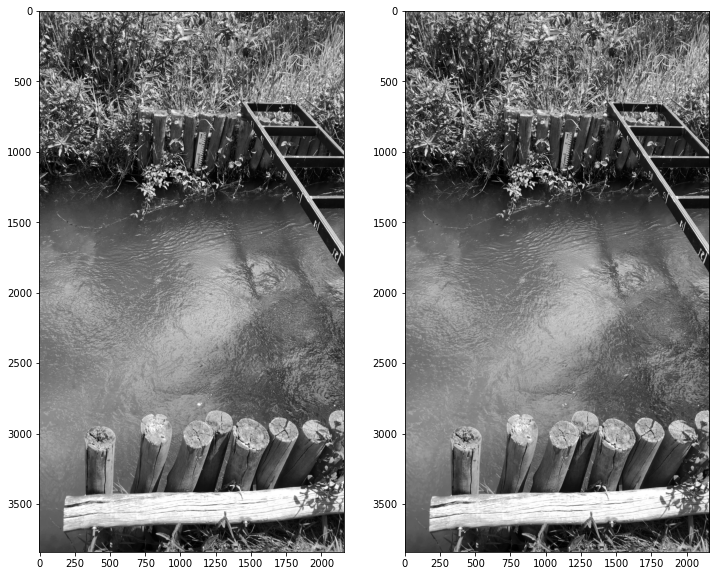

In [6]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [7]:
winsize =  64 # pixels, interrogation window size in frame A
searchsize = 120  # pixels, search in image B
overlap = 32 # pixels, 50% overlap
dt = 1/30 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [8]:
x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [9]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.03 )
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [10]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=10, 
                                  kernel_size=2)

In [11]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 96.52 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [12]:
#save in the simple ASCII table format
tools.save(x, y, u3, v3, mask, 'results/openpiv/exp1_001.txt' )

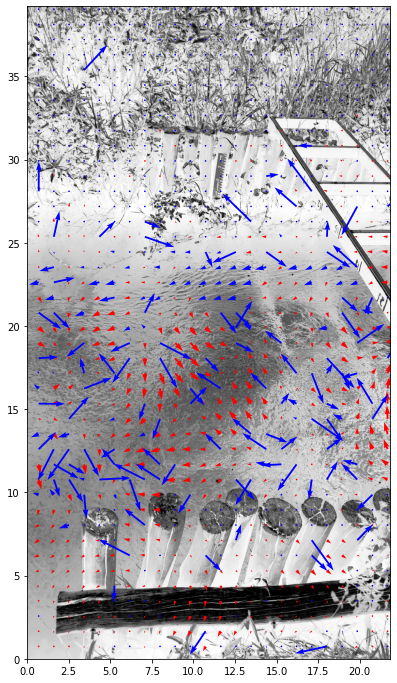

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
tools.display_vector_field('results/openpiv/exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=200, # scale defines here the arrow length
                           width=0.005, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='data/IMG_1132/frame0.jpg');
fig.savefig('results/openpiv/test.png')

In [32]:
df = pd.read_csv('results/openpiv/exp1_001.txt', sep='\t')
df

,# x,y,u,v,mask
0,0.7045,39.0385,-0.3125,0.2321,0.0
1,1.6162,39.0385,-0.2785,0.2055,0.0
2,2.5280,39.0385,-0.3025,0.2388,0.0
3,3.4397,39.0385,-0.2938,0.2347,0.0
4,4.3514,39.0385,-0.3238,0.1862,0.0
...,...,...,...,...,...
1027,18.0274,0.7460,-17.4919,-3.7678,0.0
1028,18.9391,0.7460,0.0908,-0.6281,0.0
1029,19.8508,0.7460,-1.5267,-0.9691,1.0
1030,20.7625,0.7460,-0.3258,-0.7745,1.0


In [30]:
df.describe()

,# x,y,u,v,mask
count,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,11.189392,19.892251,-0.369248,-0.509933,0.453488
std,6.314217,11.319731,3.606218,3.594829,0.498073
min,0.704500,0.746000,-17.491900,-17.309000,0.000000
25%,5.946975,9.863200,-1.318650,-1.319375,0.000000
50%,11.189400,19.892300,-0.116700,-0.109700,0.000000
75%,16.431825,29.921300,0.082275,0.070225,1.000000
max,21.674300,39.038500,17.500800,18.006500,1.000000


<AxesSubplot:>

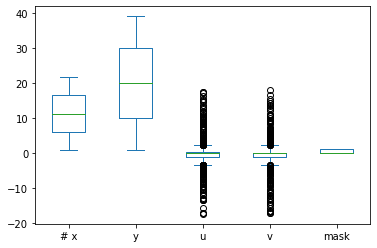

In [31]:
df.plot(kind='box')

In [39]:
def velocity_vectors(path_frame_a, path_frame_b, winsize=64, searchsize=120, overlap=32, dt=1/30, save_fig=False):
    winsize =  winsize # pixels, interrogation window size in frame A
    searchsize = searchsize  # pixels, search in image B
    overlap = overlap # pixels, 50% overlap
    dt = dt # sec, time interval between pulses

    frame_a = resize_rgb.resize(path_frame_a)
    frame_b = resize_rgb.resize(path_frame_b)

    now = datetime.datetime.now().strftime("%Y%m%d%H%M")

    if os.path.exists('piv_results'):
        print('Result folder already exists')
    else:
        os.mkdir('piv_results')
        print('Result folder created...')

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                        frame_b.astype(np.int32), 
                                                        window_size=winsize, 
                                                        overlap=overlap, 
                                                        dt=dt, 
                                                        search_area_size=searchsize, 
                                                        sig2noise_method='peak2peak')
    x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                    search_area_size=searchsize, 
                                    overlap=overlap )

    u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                            sig2noise, 
                                            threshold = 1.03 )
    # if you need more detailed look, first create a histogram of sig2noise
    # plt.hist(sig2noise.flatten())
    # to see where is a reasonable limit    

    # filter out outliers that are very different from the
    # neighbours

    u2, v2 = filters.replace_outliers( u1, v1, 
                                    method='localmean', 
                                    max_iter=10, 
                                    kernel_size=2)

    # convert x,y to mm
    # convert u,v to mm/sec

    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                                scaling_factor = 96.52 ) # 96.52 microns/pixel

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

    #save in the simple ASCII table format
    tools.save(x, y, u3, v3, mask, f'piv_results/{now}.txt' )

    fig, ax = plt.subplots(figsize=(12,12))
    tools.display_vector_field(f'piv_results/{now}.txt', 
                            ax=ax, scaling_factor=96.52, 
                            scale=500, # scale defines here the arrow length
                            width=0.001, # width is the thickness of the arrow
                            on_img=True, # overlay on the image
                            image_name=path_frame_a)

    if save_fig:
        fig.savefig(f'piv_results/{now}.png')

Result folder already exists


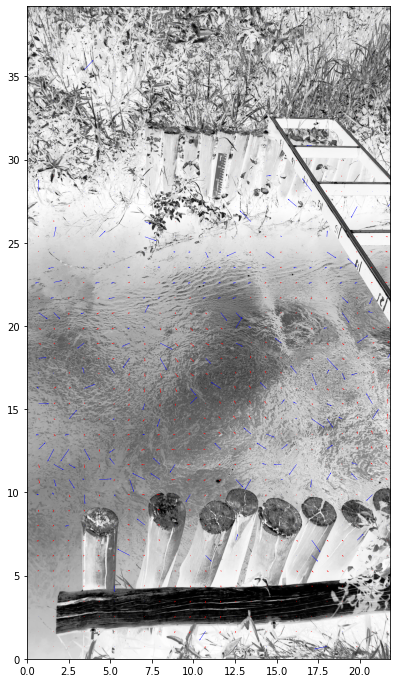

In [40]:
velocity_vectors('data/IMG_1132/frame0.jpg', 'data/IMG_1132/frame1.jpg')